In [111]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold

filename= "C:/Users/Komal/Desktop/mlp/Kobe/data.csv"
raw = pd.read_csv(filename)
#raw.head()
#raw[pd.notnull(raw['shot_made_flag'])]

In [112]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'game_event_id', 'game_id', 'game_date']
for drop in drops:
    raw = raw.drop(drop, 1)

categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'season']
for var in categorical_vars:
    raw = pd.concat([raw, pd.get_dummies(raw[var], prefix=var)], 1)
    raw = raw.drop(var, 1)

#raw.head()

In [113]:
df = raw[pd.notnull(raw['shot_made_flag'])]
indexOfNull = raw[raw['shot_made_flag'].isnull()].index.tolist()

submission = raw[pd.isnull(raw['shot_made_flag'])]

submission = submission.drop('shot_made_flag', 1)

In [114]:
import random
per_test =  round((15 * len(df))/100)
n =[0 for i in range(per_test)]

m = len(indexOfNull)-1
for z in range(per_test):
    c = indexOfNull[m]+1
    x = raw.iloc[c]
    #print(pd.notnull(x['shot_made_flag']))
    flg = 0
    if(pd.isnull(x['shot_made_flag'])):
        #print(c)
        flg =1
        while flg==1:
            c = c+1
            x = raw.iloc[c]
            if pd.notnull(x['shot_made_flag']):
                flg =0
    n[z] = c
    m=m-1;



test_comp = raw.iloc[n]
test = test_comp.drop('shot_made_flag', 1)
test_y = test_comp['shot_made_flag']
df = raw.drop(raw.index[n])
df= df[pd.notnull(df['shot_made_flag'])]
# separate df into explanatory and response variables
train = df.drop('shot_made_flag', 1)
train_y = df['shot_made_flag']

In [115]:
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

In [116]:
from sklearn.metrics import confusion_matrix
import time


# find the best n_estimators for RandomForestClassifier
print('Finding best n_estimators for RandomForestClassifier...')
min_score = 100000
best_n = 0
scores_n = []
range_n = np.logspace(0,2,num=3).astype(int)

for n in range_n:
    print("the number of trees : {0}".format(n))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(n_estimators=n)
    for train_k, test_k in KFold(len(train), n_folds=10, shuffle=True):
        rfc.fit(train.iloc[train_k], train_y.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    scores_n.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n
        
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(n, t2-t1))
print(best_n, min_score)

# find best max_depth for RandomForestClassifier
print('Finding best max_depth for RandomForestClassifier...')
min_score = 100000
best_m = 0
scores_m = []
range_m = np.logspace(0,2,num=3).astype(int)
for m in range_m:
    print("the max depth : {0}".format(m))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(max_depth=m, n_estimators=best_n)
    for train_k, test_k in KFold(len(train), n_folds=10, shuffle=True):
        rfc.fit(train.iloc[train_k], train_y.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    scores_m.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_m = m
    
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(m, t2-t1))
print(best_m, min_score)

Finding best n_estimators for RandomForestClassifier...
the number of trees : 1
Done processing 1 trees (0.996sec)
the number of trees : 10
Done processing 10 trees (4.919sec)
the number of trees : 100
Done processing 100 trees (46.707sec)
100 11.48067540842939
Finding best max_depth for RandomForestClassifier...
the max depth : 1
Done processing 1 trees (4.811sec)
the max depth : 10
Done processing 10 trees (16.915sec)
the max depth : 100
Done processing 100 trees (51.472sec)
10 11.002084903516849


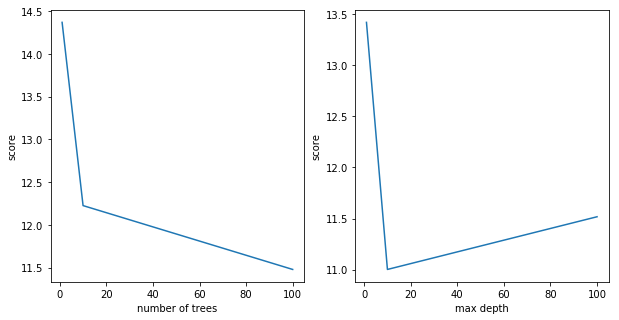

In [117]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('number of trees')

plt.subplot(122)
plt.plot(range_m, scores_m)
plt.ylabel('score')
plt.xlabel('max depth')

In [118]:
model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m)
model.fit(train, train_y)
pred_prob = model.predict_proba(train)
pred_tes_probt = model.predict_proba(test)


pred_train = model.predict(train)
pred = model.predict(submission)
pred_test = model.predict(test)


In [119]:

# Calculate the absolute errors
errors = abs(pred_train - train_y)
# Print out the mean absolute error (mae)
print('Mean Absolute Train Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors )
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Train Accuracy:', round(accuracy, 2), '%.')


# Calculate the absolute errors
errors1 = abs(pred_test - test_y)
# Print out the mean absolute error (mae)
print('Mean Absolute Test Error:', round(np.mean(errors1), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors1 )
# Calculate and display accuracy
accuracy1 = 100 - np.mean(mape)
print('Test Accuracy:', round(accuracy1, 2), '%.')



Mean Absolute Train Error: 0.31 degrees.
Train Accuracy: 69.34 %.
Mean Absolute Test Error: 0.33 degrees.
Test Accuracy: 67.39 %.


In [54]:
sub = pd.read_csv("C:/Users/Komal/Desktop/mlp/Kobe/sample_submission.csv")
sub['shot_made_flag'] = pred
sub.to_csv("real_submission_train_results.csv", index=False)